##XGBOOST  on Image and Text Embeddings 


Submitted by Akriti Gupta, Bhumika Singhal and Namita Shukla

In [1]:
!pip install xgboost==0.80

     |████████████████████████████████| 15.8 MB 8.4 MB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [2]:
#  Here we make all the imports required 
import pandas as pd
import numpy as np
import random, time
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix
from tqdm.notebook import tqdm, trange
import json

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

from xgboost import XGBRegressor,XGBClassifier
import sklearn.metrics as metrics


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Importing all the Concat Embeddings of Text and Images reducing them to 100 dim using PCA. 

In [4]:
concat_embeddings = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/Retrain-Concat-150T-50I/ConcatEmbeddings_train.csv")
concat_embeddings.rename(columns={"0": "id"}, inplace=True)

In [5]:
concat_embeddings_val = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/Retrain-Concat-150T-50I/ConcatEmbeddings_dev_unseen.csv")
concat_embeddings_val.rename(columns={"0": "id"}, inplace=True)

In [6]:
concat_embeddings_test_unseen = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/Retrain-Concat-150T-50I/ConcatEmbeddings_test_unseen.csv")
concat_embeddings_test_unseen.rename(columns={"0": "id"}, inplace=True)
concat_embeddings_test_seen = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/Retrain-Concat-150T-50I/ConcatEmbeddings_test_seen.csv")
concat_embeddings_test_seen.rename(columns={"0": "id"}, inplace=True)

In [7]:
train_data = pd.read_json("/content/gdrive/MyDrive/522-project/train.jsonl", lines=True)


train_embed = concat_embeddings[concat_embeddings.id.isin(train_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
target_train = train_data["label"].tolist()
train_embed = np.array(train_embed)
target_train = np.array(target_train)


In [8]:
val_data = pd.read_json("/content/gdrive/MyDrive/522-project/dev_unseen.jsonl", lines=True)

val_embed= concat_embeddings_val[concat_embeddings_val.id.isin(val_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
val_target = val_data["label"].tolist()

val_embed = np.array(val_embed)
val_target = np.array(val_target)

In [9]:
test_unseen_data = pd.read_json("/content/gdrive/MyDrive/522-project/test_unseen.jsonl", lines=True)

test_unseen_embed= concat_embeddings_test_unseen[concat_embeddings_test_unseen.id.isin(test_unseen_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
test_unseen_target = test_unseen_data["label"].tolist()

test_unseen_embed = np.array(test_unseen_embed)
test_unseen_target = np.array(test_unseen_target)

In [10]:
test_seen_data = pd.read_json("/content/gdrive/MyDrive/522-project/test_seen.jsonl", lines=True)

test_seen_embed= concat_embeddings_test_seen[concat_embeddings_test_seen.id.isin(test_seen_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
test_seen_target = test_seen_data["label"].tolist()

test_seen_embed = np.array(test_seen_embed)
test_seen_target = np.array(test_seen_target)

## Fitting the cocatenated Train embedding on the XGBoost Model

We fine tuned the XGBoost model on various parameters such as :  

1. n-estimators
2. Learning rate
3. Early stopping
4. maximum depth

Training the model 

In [11]:
model_xg = XGBClassifier(n_estimators=1000, learning_rate=0.05, objective = "multi:softmax" , num_class = 2, max_depth=6 )# n_jobs=4
model_xg.fit(train_embed, target_train,
            early_stopping_rounds=50, 
            eval_set=[(val_embed,val_target)], 
            eval_metric='mlogloss',
            verbose=False)

XGBClassifier(learning_rate=0.05, max_depth=6, n_estimators=1000, num_class=2,
              objective='multi:softmax')

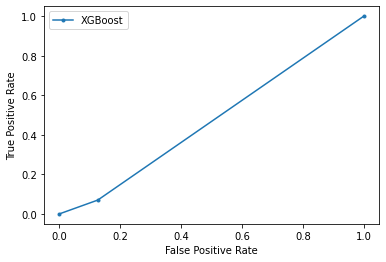

precision :0.24561403508771928 recall :0.07 f1 :0.10894941634241245 accuracy :0.575925925925926


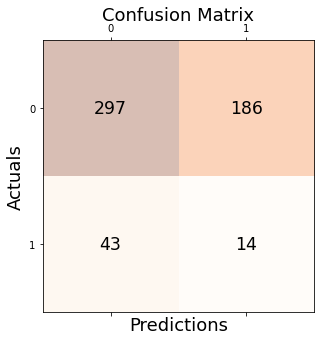

Precision vs Recall


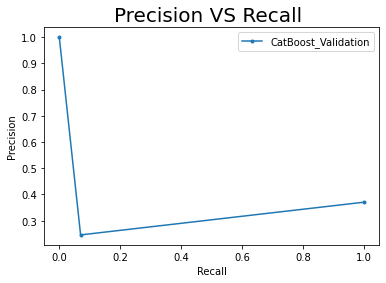

In [12]:
pred_y_xg_val = model_xg.predict(val_embed)
lr_probs = model_xg.predict_proba(val_embed) 
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(val_target, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(val_target, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

precision, recall, f1, _ = precision_recall_fscore_support(val_target, pred_y_xg_val, average='binary')
acc = accuracy_score(val_target, pred_y_xg_val)
r = confusion_matrix(pred_y_xg_val, val_target)
print("precision :"+str(precision) +" recall :"+str(recall)+" f1 :"+ str(f1)  + " accuracy :" + str(acc))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
print("Precision vs Recall")
precision1, recall1, thresholds = precision_recall_curve(val_target, pred_y_xg_val)
pyplot.plot(recall1, precision1, marker='.', label='CatBoost_Validation')
# axis labels
pyplot.title('Precision VS Recall ', fontsize=20)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()





In [13]:
print("ROC Curve : " + str(lr_auc))

ROC Curve : 0.471764705882353


## Testing on Test Seen Data

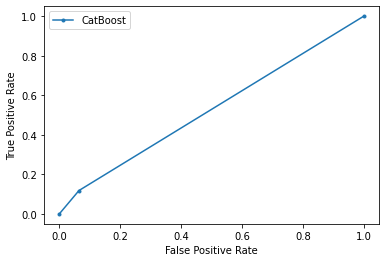

precision :0.6373626373626373 recall :0.11836734693877551 f1 :0.19965576592082615 accuracy :0.535


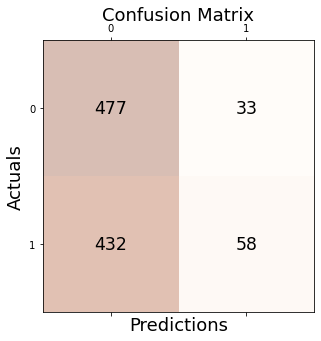

Precision vs Recall


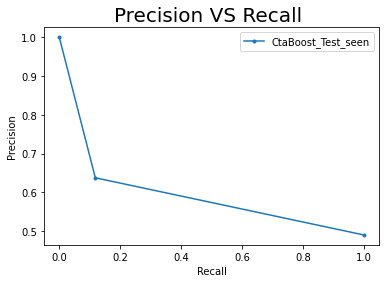

In [14]:
preds = model_xg.predict(test_seen_embed)
lr_probs = model_xg.predict_proba(test_seen_embed) 
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(test_seen_target, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_seen_target, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='CatBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
precision, recall, f1, _ = precision_recall_fscore_support(test_seen_target, preds, average='binary')
acc = accuracy_score(test_seen_target, preds)

r = confusion_matrix(test_seen_target, preds)
print("precision :"+str(precision) +" recall :"+str(recall)+" f1 :"+ str(f1)  + " accuracy :" + str(acc))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
print("Precision vs Recall")
precision1, recall1, thresholds = precision_recall_curve(test_seen_target, preds)
pyplot.plot(recall1, precision1, marker='.', label='CtaBoost_Test_seen')
# axis labels
pyplot.title('Precision VS Recall ', fontsize=20)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [15]:
print("ROC Curve : " + str(lr_auc))

ROC Curve : 0.5268307322929172


## Testing on the unseen test data

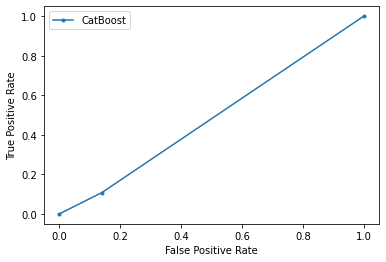

precision :0.31640625 recall :0.108 f1 :0.1610337972166998 accuracy :0.578


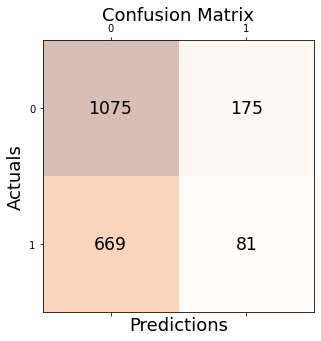

Precision vs Recall


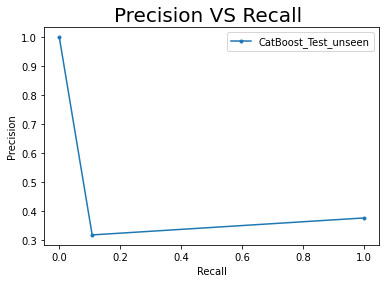

In [16]:
preds = model_xg.predict(test_unseen_embed)
lr_probs = model_xg.predict_proba(test_unseen_embed) 
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(test_unseen_target, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_unseen_target, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='CatBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
precision, recall, f1, _ = precision_recall_fscore_support(test_unseen_target, preds, average='binary')
acc = accuracy_score(test_unseen_target, preds)
r = confusion_matrix(test_unseen_target, preds)
print("precision :"+str(precision) +" recall :"+str(recall)+" f1 :"+ str(f1)  + " accuracy :" + str(acc))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

precision1, recall1, thresholds = precision_recall_curve(test_unseen_target, preds)
print("Precision vs Recall")
pyplot.plot(recall1, precision1, marker='.', label='CatBoost_Test_unseen')
# axis labels
pyplot.title('Precision VS Recall ', fontsize=20)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [17]:
print("ROC Curve : " + str(lr_auc))

ROC Curve : 0.48400000000000004
